In [1]:
import re

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Log in to your WandB account
wandb.login()

# Initialize the WandB API
api = wandb.Api()

wandb: Currently logged in as: johannes-burmester (SoSe2024-NLP-Lab). Use `wandb login --relogin` to force relogin


In [3]:
# Specify the project names
projects = ['Downstream_SciBert_MedQA',
            'Downstream_SciBert_MedNLI',
            'Downstream_SciBert_HoC',
            'Downstream_SciBert_BioASQ',
            'Downstream_BioBert_MedQA',
            'Downstream_BioBert_MedNLI',
            'Downstream_BioBert_HoC',
            'Downstream_BioBert_BioASQ',
            'Downstream_PubMedBert_MedQA',
            'Downstream_PubMedBert_MedNLI',
            'Downstream_PubMedBert_HoC',
            'Downstream_PubMedBert_BioASQ',
            'Downstream_SciBert_PubMedQa',
            'Downstream_BioBert_PubMedQa',
            'Downstream_PubMedBert_PubMedQa']
# projects = [proj.name for proj in api.projects()][:14]

In [89]:
# List to store data from all runs
all_data = []

# Function to extract components from the run name
def extract_components(run_name):
    components = run_name.split('_')
    
    # Identify the index of epochs and batch size components
    epochs_index = next((i for i, s in enumerate(components) if 'epochs' in s), None)
    batch_size_index = next((i for i, s in enumerate(components) if 'batch' in s), None)
    run_index = next((i for i, s in enumerate(components) if 'run' in s), None)
    
    # Extract finetuning, epochs, batch size, and adapter type
    finetuning = '_'.join(components[:epochs_index])
    epochs = re.findall(r'\d+', components[epochs_index])[0] if epochs_index is not None else None
    batch_size = re.findall(r'\d+', components[batch_size_index])[0] if batch_size_index is not None else None
    if finetuning == "only_model":
        adapter_type = "only_model"
        fine_adapter = "only_model"
    elif finetuning == "only_fusion":
        adapter_type = '_'.join(components[run_index+1:]) if run_index is not None and run_index + 1 < len(components) else None
        fine_adapter = "only_fusion " + adapter_type
    elif finetuning == "model+adapter" or finetuning == "model+adapters":
        finetuning = "model+adapter"
        adapter_type = '_'.join(components[run_index+1:]) if run_index is not None and run_index + 1 < len(components) else None
        fine_adapter = "model+adapter " + adapter_type
    else:
        adapter_type = None
        fine_adapter = None
    
    return finetuning, int(epochs) if epochs else None, int(batch_size) if batch_size else None, adapter_type, fine_adapter

# Iterate over each project and fetch its runs
for project in projects:
    runs = api.runs(project)
    for run in runs:
        # Access summary metrics directly
        summary_metrics = run.summary

        # Check if the summary contains the 'eval/accuracy' metric
        if 'eval/accuracy' in summary_metrics:
            # Extract components from the run name
            finetuning, epochs, batch_size, adapter_type, fine_adapter = extract_components(run.name)
            
            # Split the project name into components
            project_components = project.split('_')
            if len(project_components) >= 3:
                base_model = project_components[1]
                task = project_components[2]

                # Create a dictionary with the relevant metrics
                run_data = {
                    'project': project,
                    'run': run.name,
                    'base_model': base_model,
                    'task': task,
                    'finetuning': finetuning,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'adapter_type': adapter_type,
                    'finetuning+adapter': fine_adapter,
                    'eval/accuracy': summary_metrics['eval/accuracy'],
                    'train_runtime': summary_metrics['train_runtime']
                }
                all_data.append(run_data)

# Convert the list of dictionaries to a DataFrame
all_data_df = pd.DataFrame(all_data)

# Group by the relevant columns and aggregate the accuracies into lists, means, and standard deviations
grouped_data = all_data_df.groupby(['base_model', 'task', 'finetuning', 'epochs', 'batch_size', 'adapter_type', 'finetuning+adapter']).agg(
    eval_accuracy_list=('eval/accuracy', list),
    mean_accuracy=('eval/accuracy', 'mean'),
    std_accuracy=('eval/accuracy', 'std'),
    train_runtime_list=('train_runtime', list),
    mean_runtime=('train_runtime', 'mean'),
    std_runtime=('train_runtime', 'std'),
).reset_index()

all_data_df

,project,run,base_model,task,finetuning,epochs,batch_size,adapter_type,finetuning+adapter,eval/accuracy,train_runtime
0,Downstream_SciBert_MedQA,model+adapter_25epochs_12batch size_run0_EP_NB,SciBert,MedQA,model+adapter,25,12,EP_NB,model+adapter EP_NB,0.320660,5518.6259
1,Downstream_SciBert_MedQA,model+adapter_25epochs_12batch size_run1_EP_NB,SciBert,MedQA,model+adapter,25,12,EP_NB,model+adapter EP_NB,0.318008,5552.9421
2,Downstream_SciBert_MedQA,model+adapter_25epochs_12batch size_run2_EP_NB,SciBert,MedQA,model+adapter,25,12,EP_NB,model+adapter EP_NB,0.326946,5544.4896
3,Downstream_SciBert_MedQA,model+adapter_25epochs_12batch size_run0_LP_NB,SciBert,MedQA,model+adapter,25,12,LP_NB,model+adapter LP_NB,0.323902,5515.4494
4,Downstream_SciBert_MedQA,model+adapter_25epochs_12batch size_run1_LP_NB,SciBert,MedQA,model+adapter,25,12,LP_NB,model+adapter LP_NB,0.318008,5549.7422
...,...,...,...,...,...,...,...,...,...,...,...
564,Downstream_PubMedBert_PubMedQa,model+adapters_25epochs_12batch size_run5_EP,PubMedBert,PubMedQa,model+adapter,25,12,EP,model+adapter EP,0.760000,1165.2533
565,Downstream_PubMedBert_PubMedQa,model+adapters_25epochs_12batch size_run6_EP,PubMedBert,PubMedQa,model+adapter,25,12,EP,model+adapter EP,0.720000,1164.7609
566,Downstream_PubMedBert_PubMedQa,model+adapters_25epochs_12batch size_run7_EP,PubMedBert,PubMedQa,model+adapter,25,12,EP,model+adapter EP,0.640000,1164.2524
567,Downstream_PubMedBert_PubMedQa,model+adapters_25epochs_12batch size_run8_EP,PubMedBert,PubMedQa,model+adapter,25,12,EP,model+adapter EP,0.560000,1164.8658


In [90]:
grouped_data

,base_model,task,finetuning,epochs,batch_size,adapter_type,finetuning+adapter,eval_accuracy_list,mean_accuracy,std_accuracy,train_runtime_list,mean_runtime,std_runtime
0,BioBert,BioASQ,model+adapter,25,8,EP_NB,model+adapter EP_NB,"[0.88, 0.84, 0.7866666666666666, 0.85135135135...",0.826342,0.047428,"[575.3604, 578.9898, 579.8366, 578.1873, 583.1...",669.12155,282.174326
1,BioBert,BioASQ,model+adapter,25,8,LP_FULL,model+adapter LP_FULL,"[0.8533333333333334, 0.8266666666666667, 0.76,...",0.830486,0.045985,"[248.5403, 248.3748, 248.484, 248.4333, 247.82...",248.29084,0.719945
2,BioBert,BioASQ,model+adapter,25,8,LP_NB,model+adapter LP_NB,"[0.84, 0.8266666666666667, 0.7866666666666666,...",0.816955,0.029936,"[569.8309, 570.9862, 569.4835, 568.838, 569.77...",577.79325,11.806667
3,BioBert,BioASQ,only_model,25,8,only_model,only_model,"[0.76, 0.8533333333333334, 0.8133333333333334,...",0.842667,0.040915,"[178.897, 177.7518, 177.6039, 179.5957, 179.04...",178.91840,0.775289
4,BioBert,HoC,model+adapter,25,16,EP_NB,model+adapter EP_NB,"[0.8419540229885057, 0.8523706896551724, 0.848...",0.846087,0.005982,"[6894.3659, 6859.027, 6905.4187, 6933.5738, 70...",6923.66522,63.102969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,SciBert,PubMedQa,model+adapter,25,12,EP_NB,model+adapter EP_NB,"[0.56, 0.56, 0.6, 0.52, 0.58, 0.62, 0.56, 0.56...",0.588000,0.047329,"[294.5032, 294.1481, 294.7709, 294.5675, 293.8...",767.80252,1493.347664
80,SciBert,PubMedQa,model+adapter,25,12,LP,model+adapter LP,"[0.56, 0.56, 0.6, 0.52, 0.58, 0.62, 0.56, 0.56...",0.588000,0.047329,"[294.2431, 293.6763, 293.0738, 295.15, 293.396...",294.01712,0.644615
81,SciBert,PubMedQa,model+adapter,25,12,LP_FULL,model+adapter LP_FULL,"[0.64, 0.56, 0.6, 0.52, 0.58, 0.62, 0.56, 0.56...",0.596000,0.048808,"[295.3466, 293.9105, 294.2934, 294.0091, 293.6...",294.29010,0.663495
82,SciBert,PubMedQa,model+adapter,25,12,LP_NB,model+adapter LP_NB,"[0.58, 0.56, 0.6, 0.52, 0.58, 0.62, 0.56, 0.56...",0.590000,0.046428,"[294.8468, 294.1055, 295.5139, 294.1732, 294.1...",294.38024,0.542950


In [91]:
# Save the DataFrame to a CSV file
grouped_data.to_csv("wandb_all_projects_metrics.csv", index=False)

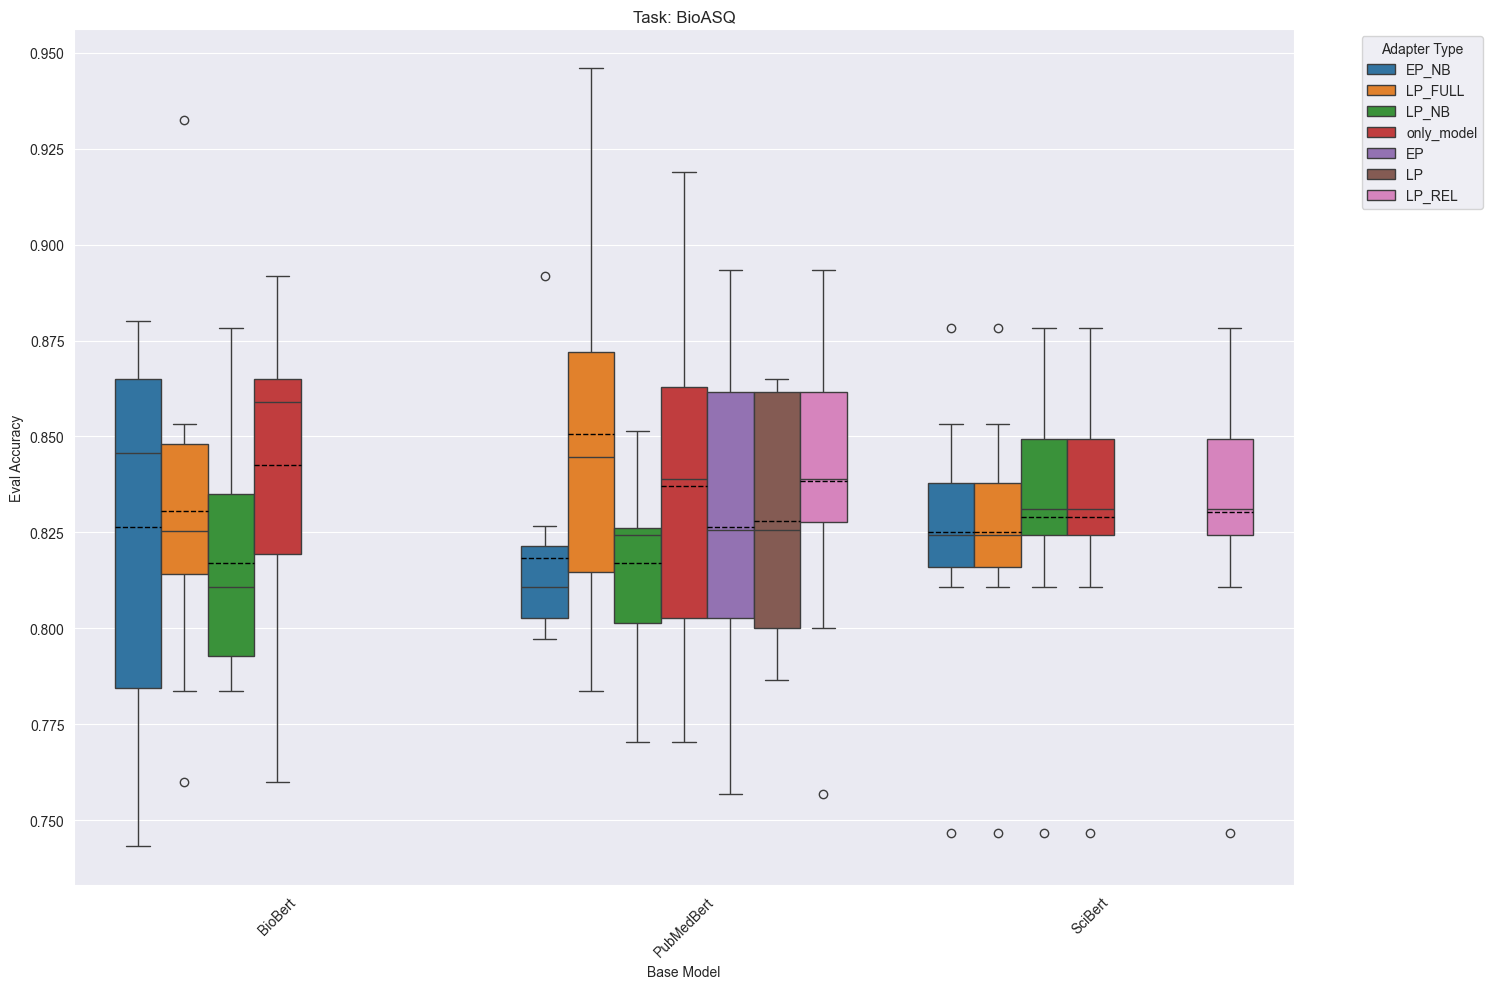

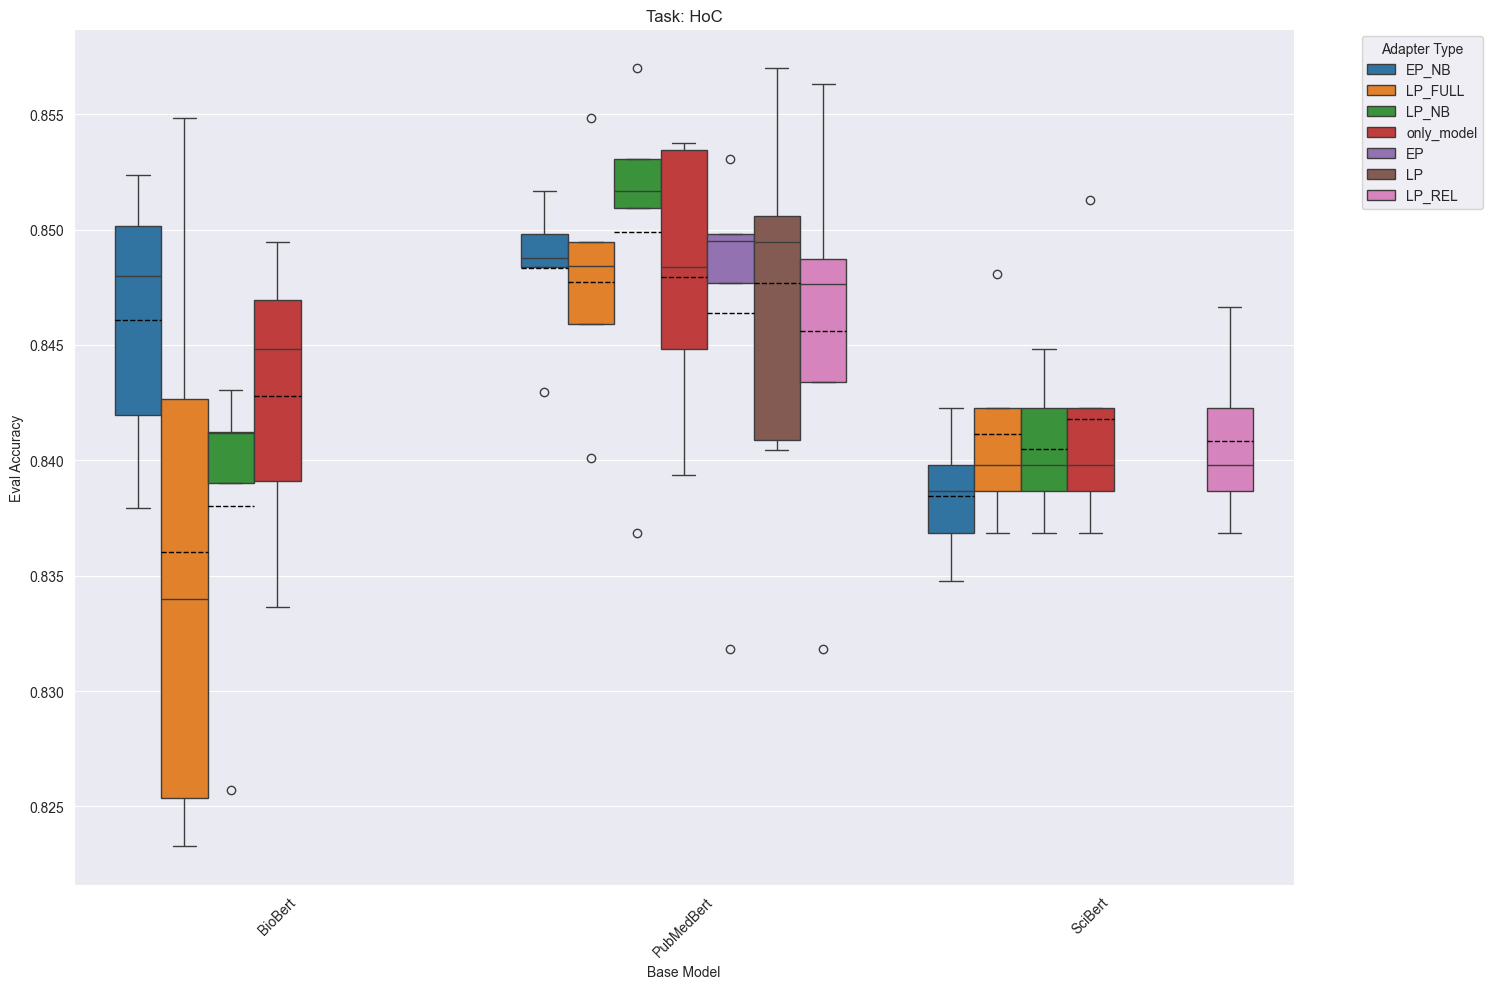

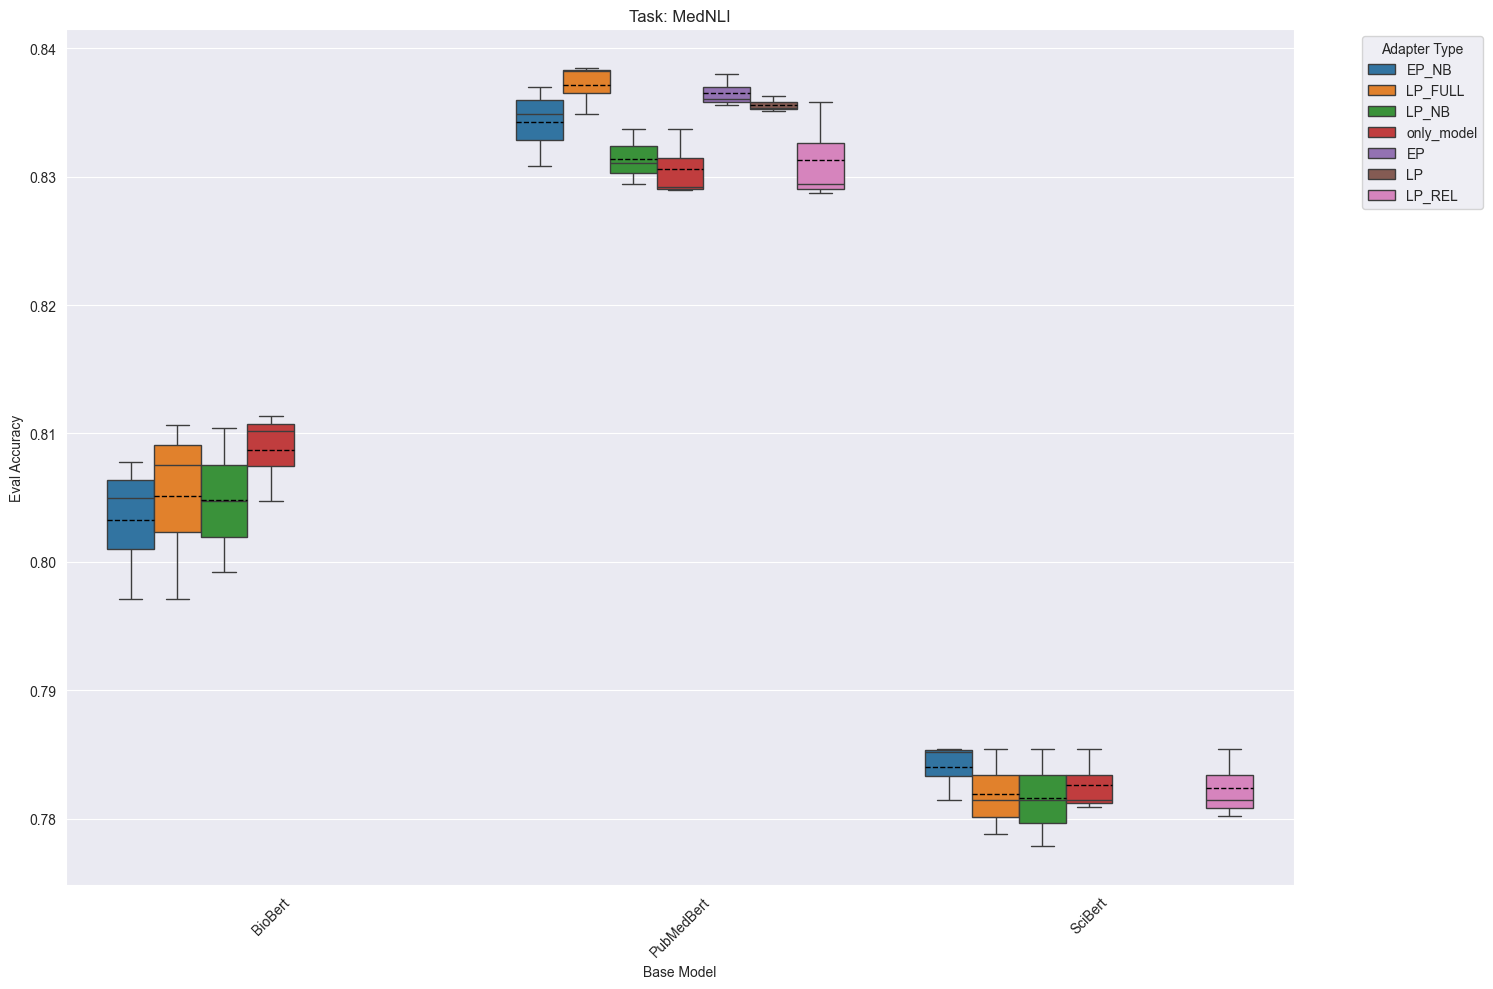

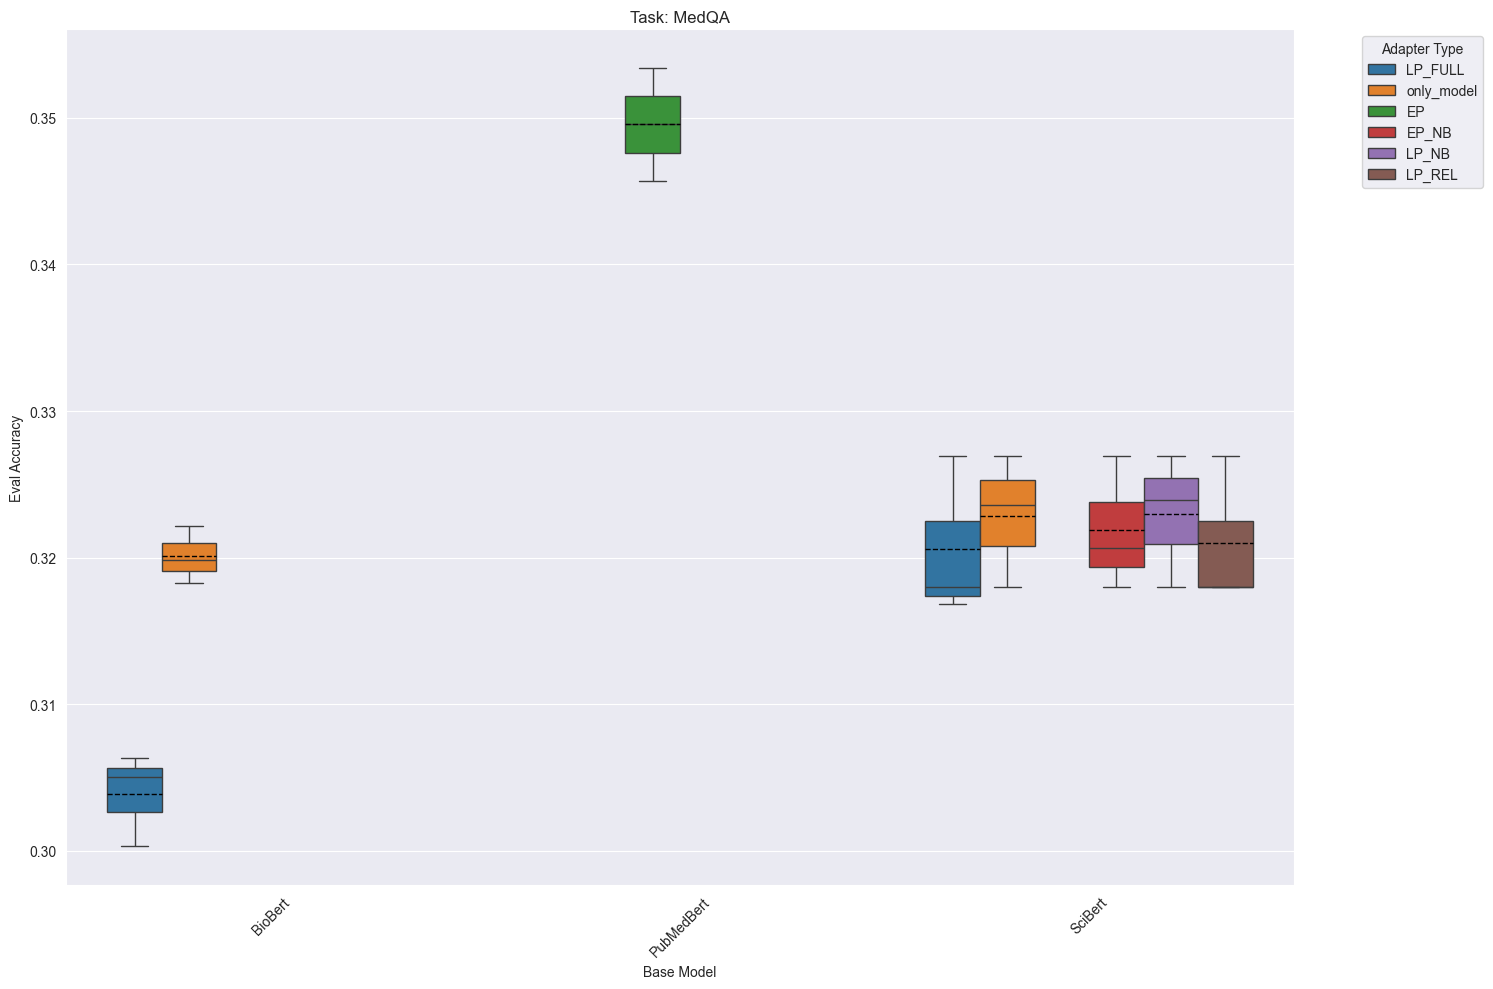

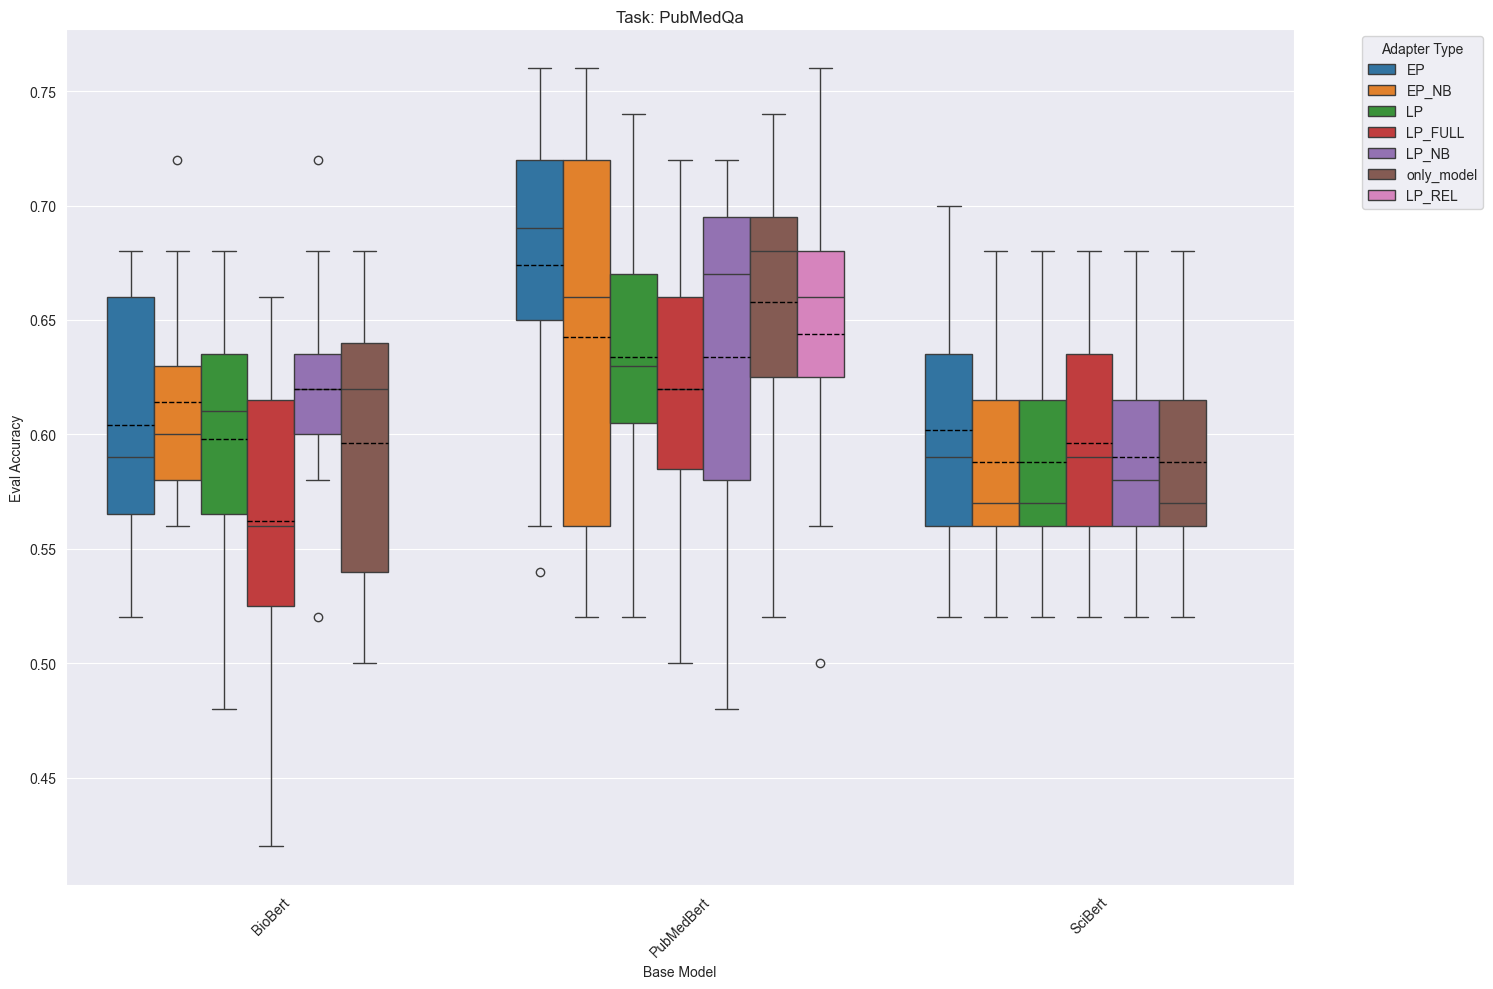

In [92]:
from matplotlib.lines import Line2D

# Create box plots for each task
tasks = grouped_data['task'].unique()

for task in tasks:
    
    task_data = grouped_data[
        (grouped_data['task'] == task) & 
        (grouped_data['finetuning'].isin(['model+adapter', 'only_model']))
    ]
    plt.figure(figsize=(15, 10))
    
    # Create a box plot for each base model
    base_models = task_data['base_model'].unique()
    plot_data = []
    for base_model in base_models:
        base_model_data = task_data[task_data['base_model'] == base_model]
        for index, row in base_model_data.iterrows():
            for acc in row['eval_accuracy_list']:
                plot_data.append((base_model, row['adapter_type'], acc))
    
    plot_df = pd.DataFrame(plot_data, columns=['Base Model', 'Adapter Type', 'Accuracy'])
    
    sns.boxplot(x='Base Model', y='Accuracy', hue='Adapter Type', data=plot_df, showmeans=True, meanline=True, meanprops={"color": "black"})
    
    plt.title(f'Task: {task}')
    plt.xlabel('Base Model')
    plt.ylabel('Eval Accuracy')
    plt.legend(title='Adapter Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/{task}.pdf', bbox_inches='tight')
    plt.show()

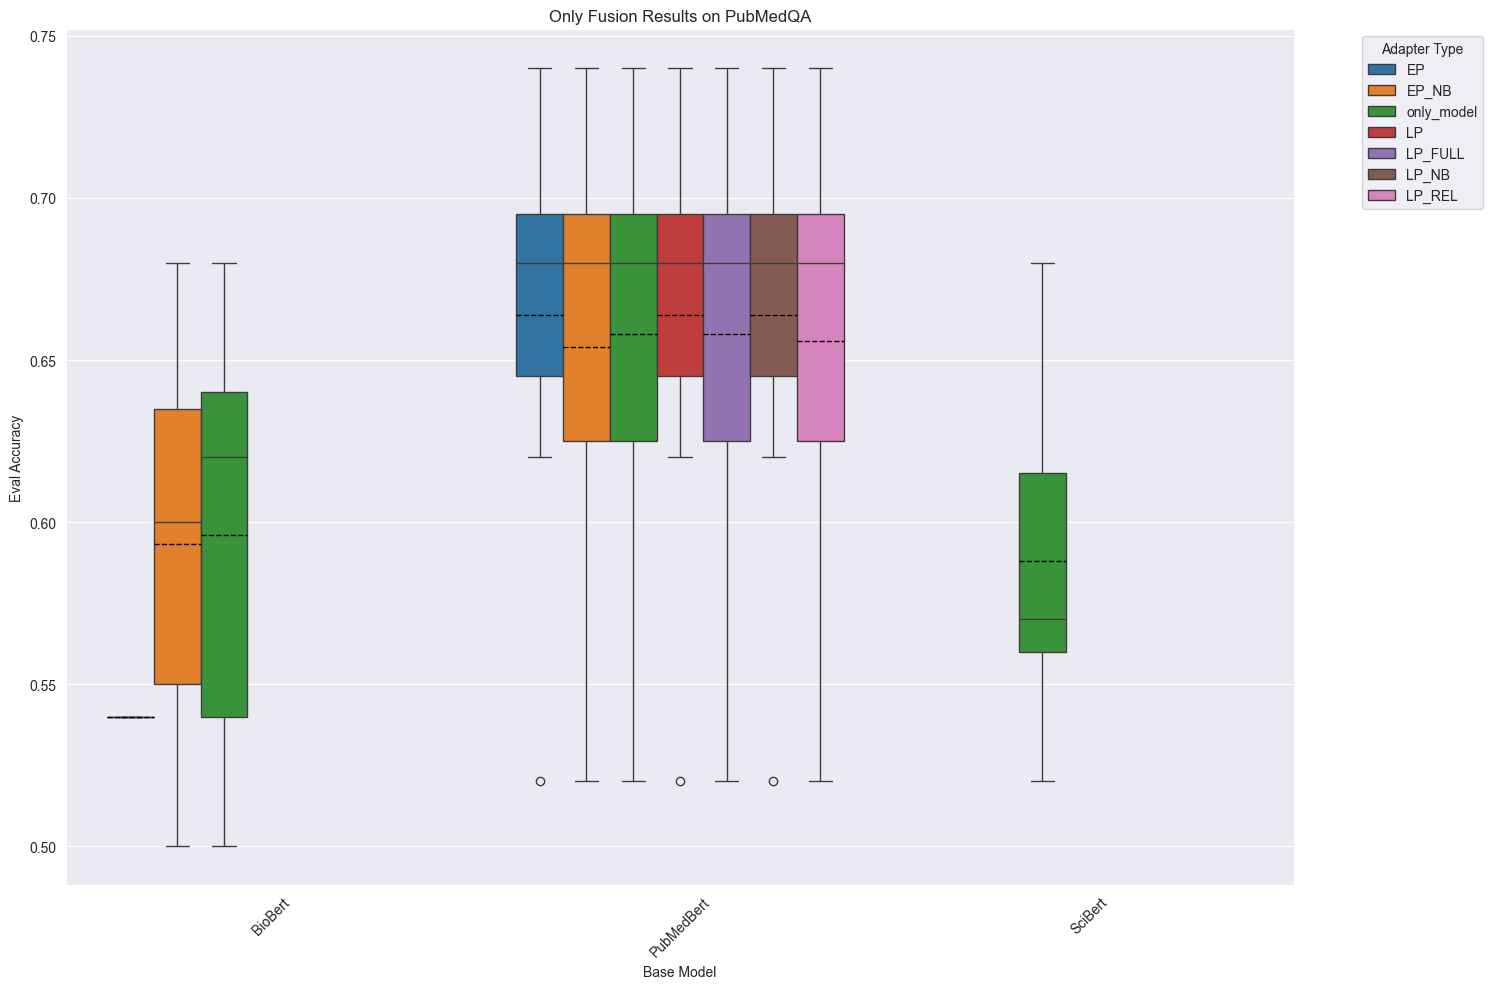

In [93]:
task_data = grouped_data[
    (grouped_data['task'] == 'PubMedQa') & 
    (grouped_data['finetuning'].isin(['only_fusion', 'only_model']))
]
plt.figure(figsize=(15, 10))

# Create a box plot for each base model
base_models = task_data['base_model'].unique()
plot_data = []
for base_model in base_models:
    base_model_data = task_data[task_data['base_model'] == base_model]
    for index, row in base_model_data.iterrows():
        for acc in row['eval_accuracy_list']:
            plot_data.append((base_model, row['adapter_type'], acc))

plot_df = pd.DataFrame(plot_data, columns=['Base Model', 'Adapter Type', 'Accuracy'])

sns.boxplot(x='Base Model', y='Accuracy', hue='Adapter Type', data=plot_df, showmeans=True, meanline=True, meanprops={"color": "black"})

plt.title(f'Only Fusion Results on PubMedQA')
plt.xlabel('Base Model')
plt.ylabel('Eval Accuracy')
plt.legend(title='Adapter Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'plots/pubmedqa_fusion.pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


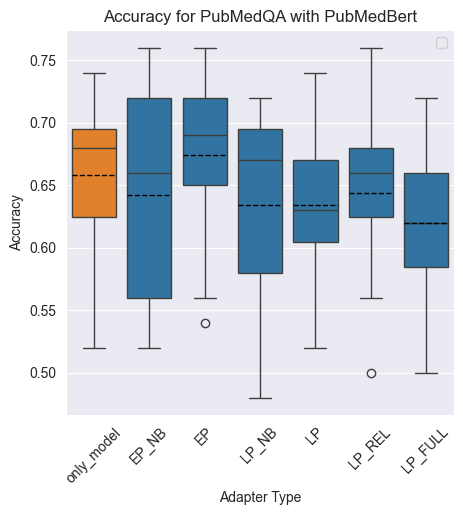

In [94]:
# Filter the data for the task PubMedQA and base_model PubMedBert
filtered_data = all_data_df[
    (all_data_df['task'] == 'PubMedQa') &
    (all_data_df['base_model'] == 'PubMedBert') &
    (all_data_df['finetuning'].isin(['model+adapter', 'only_model']))
]

# Define the order of the adapter types to ensure only_model is on the left
adapter_order = [
    'only_model',
    'EP_NB',
    'EP',
    'LP_NB',
    'LP',
    'LP_REL',
    'LP_FULL'
]

# Create the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x='adapter_type', y='eval/accuracy', data=filtered_data, order=adapter_order, hue='finetuning', legend=None, showmeans=True, meanline=True, meanprops={"color": "black"})
#sns.stripplot(x='adapter_type', y='eval/accuracy', data=filtered_data, hue='finetuning', 
#              dodge=True, jitter=True, marker='o', alpha=0.5)

# Customizing the plot
plt.title('Accuracy for PubMedQA with PubMedBert')
plt.xlabel('Adapter Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

plt.savefig('plots/pubmedqa_pubmedbert.pdf', bbox_inches='tight')
# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


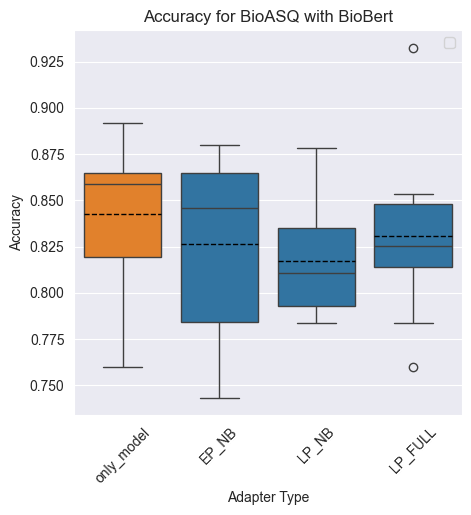

In [95]:
# Filter the data for the task BioASQ and base_model BioBert
filtered_data = all_data_df[
    (all_data_df['task'] == 'BioASQ') &
    (all_data_df['base_model'] == 'BioBert') &
    (all_data_df['finetuning'].isin(['model+adapter', 'only_model']))
]

# Define the order of the adapter types to ensure only_model is on the left
adapter_order = [
    'only_model',
    'EP_NB',
    'LP_NB',
    'LP_FULL'
]

# Create the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x='adapter_type', y='eval/accuracy', data=filtered_data, order=adapter_order, hue='finetuning', legend=None, showmeans=True, meanline=True, meanprops={"color": "black"})
#sns.stripplot(x='adapter_type', y='eval/accuracy', data=filtered_data, hue='finetuning', 
#              dodge=True, jitter=True, marker='o', alpha=0.5)

# Customizing the plot
plt.title('Accuracy for BioASQ with BioBert')
plt.xlabel('Adapter Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

plt.savefig('plots/bioasq_biobert.pdf', bbox_inches='tight')
# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


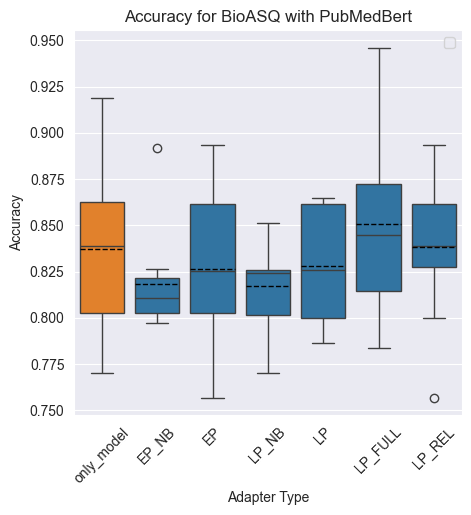

In [96]:
# Filter the data for the task BioASQ and base_model PubMedBert
filtered_data = all_data_df[
    (all_data_df['task'] == 'BioASQ') &
    (all_data_df['base_model'] == 'PubMedBert') &
    (all_data_df['finetuning'].isin(['model+adapter', 'only_model']))
]

# Define the order of the adapter types to ensure only_model is on the left
adapter_order = [
    'only_model',
    'EP_NB',
    'EP',
    'LP_NB',
    'LP',
    'LP_FULL',
    'LP_REL'
]

# Create the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x='adapter_type', y='eval/accuracy', data=filtered_data, order=adapter_order, hue='finetuning', legend=None, showmeans=True, meanline=True, meanprops={"color": "black"})
#sns.stripplot(x='adapter_type', y='eval/accuracy', data=filtered_data, hue='finetuning', 
#              dodge=True, jitter=True, marker='o', alpha=0.5)

# Customizing the plot
plt.title('Accuracy for BioASQ with PubMedBert')
plt.xlabel('Adapter Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

plt.savefig('plots/bioasq_pubmedbert.pdf', bbox_inches='tight')
# Display the plot
plt.show()

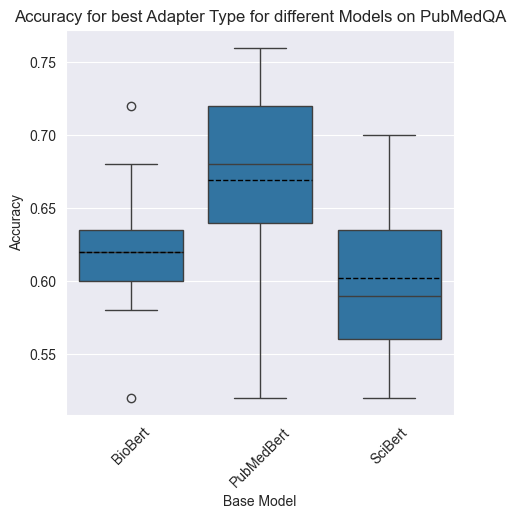

In [97]:
# Define filtering criteria
criteria = [
    {'base_model': 'BioBert', 'adapter_type': 'LP_NB'},
    {'base_model': 'PubMedBert', 'adapter_type': 'EP'},
    {'base_model': 'SciBert', 'adapter_type': 'EP'}
]

# Filter and combine data
filtered_dfs = []
for crit in criteria:
    df_filtered = all_data_df[
        (all_data_df['task'] == 'PubMedQa') &
        (all_data_df['base_model'] == crit['base_model']) &
        (all_data_df['adapter_type'] == crit['adapter_type'])
    ]
    filtered_dfs.append(df_filtered)

combined_df = pd.concat(filtered_dfs)

# Create the boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(
    x='base_model', 
    y='eval/accuracy', 
    # hue='base_model', 
    data=combined_df, 
    order=['BioBert', 'PubMedBert', 'SciBert'], 
    showmeans=True, 
    meanline=True, 
    meanprops={"color": "black"}
)

# Customizing the plot
plt.title('Accuracy for best Adapter Type for different Models on PubMedQA')
plt.xlabel('Base Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.savefig('plots/pubmedqa_models.pdf', bbox_inches='tight')
plt.show()


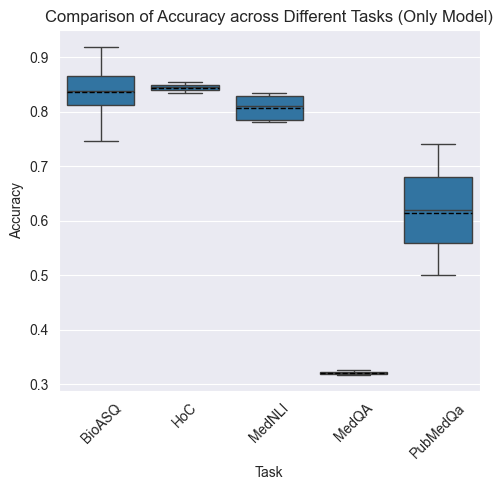

In [98]:
# Filter the data to only include the `only_model` finetuning
filtered_data = all_data_df[all_data_df['finetuning'] == 'only_model']

# Create the boxplot comparing different tasks
plt.figure(figsize=(5, 5))
sns.boxplot(
    x='task', 
    y='eval/accuracy', 
    data=filtered_data, 
    order=['BioASQ', 'HoC', 'MedNLI', 'MedQA', 'PubMedQa'], 
    showmeans=True, 
    meanline=True, 
    meanprops={"color": "black"}
)

# Customizing the plot
plt.title('Comparison of Accuracy across Different Tasks (Only Model)')
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('plots/task_comp.pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


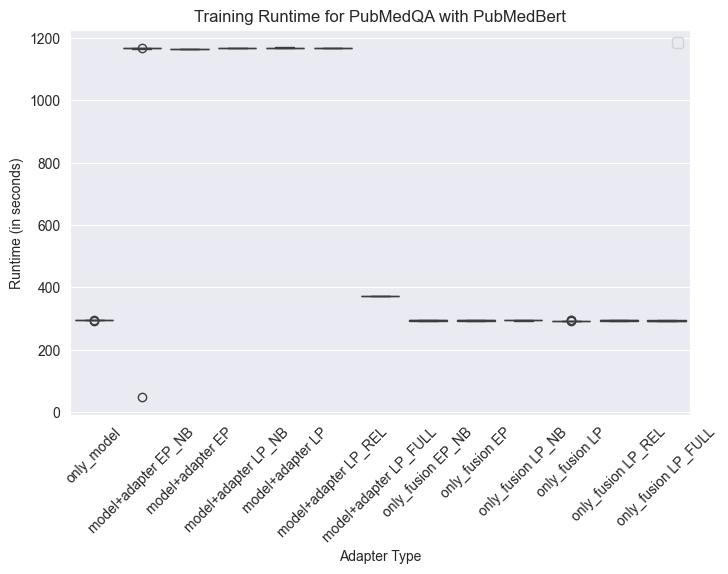

In [99]:
# Filter the data for the task PubMedQA and base_model PubMedBert
filtered_data = all_data_df[
    (all_data_df['task'] == 'PubMedQa') &
    (all_data_df['base_model'] == 'PubMedBert') 
    # (all_data_df['finetuning'].isin(['model+adapter', 'only_model']))
]

# Define the order of the adapter types to ensure only_model is on the left
adapter_order = [
    'only_model',
    'model+adapter EP_NB',
    'model+adapter EP',
    'model+adapter LP_NB',
    'model+adapter LP',
    'model+adapter LP_REL',
    'model+adapter LP_FULL',
    'only_fusion EP_NB',
    'only_fusion EP',
    'only_fusion LP_NB',
    'only_fusion LP',
    'only_fusion LP_REL',
    'only_fusion LP_FULL'
]

# Create the boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='finetuning+adapter', y='train_runtime', data=filtered_data, hue='finetuning', legend=None, order=adapter_order)
#sns.stripplot(x='adapter_type', y='eval/accuracy', data=filtered_data, hue='finetuning', 
#              dodge=True, jitter=True, marker='o', alpha=0.5)

# Customizing the plot
plt.title('Training Runtime for PubMedQA with PubMedBert')
plt.xlabel('Adapter Type')
plt.ylabel('Runtime (in seconds)')
plt.xticks(rotation=45)
plt.legend()

plt.savefig('plots/pubmedqa_pubmedbert_runtime.pdf', bbox_inches='tight')
# Display the plot
plt.show()

In [100]:
# Pivot the table to get mean accuracy and standard deviation
pivot_table = grouped_data.pivot_table(index=['base_model', 'finetuning', 'adapter_type'], 
                             columns='task', 
                             values=['mean_accuracy', 'std_accuracy'], 
                             aggfunc=np.mean)

# Combine mean accuracy and standard deviation into a single column
def combine_accuracy_std(mean, std):
    if pd.isna(mean) or pd.isna(std):
        return "N/A"
    return f"{mean:.3f} ({std:.3f})"

# Apply the function to the DataFrame
combined = pd.DataFrame()
for task in pivot_table.columns.levels[1]:
    mean_col = pivot_table['mean_accuracy', task]
    std_col = pivot_table['std_accuracy', task]
    combined[task] = mean_col.combine(std_col, combine_accuracy_std)

# Determine the correct column format
num_tasks = len(combined.columns) + len(combined.index.names)
column_format = 'l' + 'c' * num_tasks  # 'l' for index column, 'c' for data columns

# Prepare LaTeX table
latex_table = combined.to_latex(multicolumn=True, 
                                multirow=True, 
                                column_format=column_format, 
                                float_format="%.3f", 
                                na_rep="N/A", 
                                escape=True)

print(latex_table)

\begin{tabular}{lcccccccc}
\toprule
 &  &  & BioASQ & HoC & MedNLI & MedQA & PubMedQa \\
base_model & finetuning & adapter_type &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{BioBert} & \multirow[t]{5}{*}{model+adapter} & EP & N/A & N/A & N/A & N/A & 0.604 (0.057) \\
 &  & EP\_NB & 0.826 (0.047) & 0.846 (0.006) & 0.803 (0.006) & N/A & 0.614 (0.051) \\
 &  & LP & N/A & N/A & N/A & N/A & 0.598 (0.060) \\
 &  & LP\_FULL & 0.830 (0.046) & 0.836 (0.013) & 0.805 (0.007) & 0.304 (0.003) & 0.562 (0.073) \\
 &  & LP\_NB & 0.817 (0.030) & 0.838 (0.007) & 0.805 (0.006) & N/A & 0.620 (0.054) \\
\cline{2-8}
 & \multirow[t]{2}{*}{only\_fusion} & EP & N/A & N/A & N/A & N/A & N/A \\
 &  & EP\_NB & N/A & N/A & N/A & N/A & 0.593 (0.067) \\
\cline{2-8}
 & only\_model & only\_model & 0.843 (0.041) & 0.843 (0.006) & 0.809 (0.004) & 0.320 (0.002) & 0.596 (0.070) \\
\cline{1-8} \cline{2-8}
\multirow[t]{13}{*}{PubMedBert} & \multirow[t]{6}{*}{model+adapter} & EP & 0.826 (0.047) & 0.846 (0.008) & 0.837 (0.001) 

In [101]:
# Pivot the table to get mean runtime and standard deviation
pivot_table = grouped_data.pivot_table(index=['base_model', 'finetuning', 'adapter_type'], 
                             columns='task', 
                             values=['mean_runtime', 'std_runtime'], 
                             aggfunc=np.mean)

# Combine mean runtime and standard deviation into a single column
def combine_runtime_std(mean, std):
    if pd.isna(mean) or pd.isna(std):
        return "N/A"
    return f"{mean:.3f} ({std:.3f})"

# Apply the function to the DataFrame
combined = pd.DataFrame()
for task in pivot_table.columns.levels[1]:
    mean_col = pivot_table['mean_runtime', task]
    std_col = pivot_table['std_runtime', task]
    combined[task] = mean_col.combine(std_col, combine_runtime_std)

# Determine the correct column format
num_tasks = len(combined.columns) + len(combined.index.names)
column_format = 'l' + 'c' * num_tasks  # 'l' for index column, 'c' for data columns

# Prepare LaTeX table
latex_table = combined.to_latex(multicolumn=True, 
                                multirow=True, 
                                column_format=column_format, 
                                float_format="%.3f", 
                                na_rep="N/A", 
                                escape=True)

print(latex_table)

\begin{tabular}{lcccccccc}
\toprule
 &  &  & BioASQ & HoC & MedNLI & MedQA & PubMedQa \\
base_model & finetuning & adapter_type &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{BioBert} & \multirow[t]{5}{*}{model+adapter} & EP & N/A & N/A & N/A & N/A & 1172.346 (4.956) \\
 &  & EP\_NB & 669.122 (282.174) & 6923.665 (63.103) & 5312.493 (61.228) & N/A & 1179.153 (0.513) \\
 &  & LP & N/A & N/A & N/A & N/A & 1178.521 (0.975) \\
 &  & LP\_FULL & 248.291 (0.720) & 2680.106 (4.784) & 2040.887 (3.890) & 8117.851 (33.859) & 474.148 (257.458) \\
 &  & LP\_NB & 577.793 (11.807) & 6949.242 (47.102) & 5264.629 (37.774) & N/A & 1179.880 (0.772) \\
\cline{2-8}
 & \multirow[t]{2}{*}{only\_fusion} & EP & N/A & N/A & N/A & N/A & N/A \\
 &  & EP\_NB & N/A & N/A & N/A & N/A & 299.057 (0.876) \\
\cline{2-8}
 & only\_model & only\_model & 178.918 (0.775) & 2083.434 (1.921) & 1579.857 (0.925) & 6366.404 (35.026) & 299.348 (0.592) \\
\cline{1-8} \cline{2-8}
\multirow[t]{13}{*}{PubMedBert} & \multirow[t]{6}{*}{m

In [102]:
combined

BioASQ  \
base_model finetuning    adapter_type                       
BioBert    model+adapter EP                           N/A   
                         EP_NB          669.122 (282.174)   
                         LP                           N/A   
                         LP_FULL          248.291 (0.720)   
                         LP_NB           577.793 (11.807)   
           only_fusion   EP                           N/A   
                         EP_NB                        N/A   
           only_model    only_model       178.918 (0.775)   
PubMedBert model+adapter EP             837.858 (204.889)   
                         EP_NB            582.472 (8.166)   
                         LP            1882.524 (650.974)   
                         LP_FULL          242.606 (0.439)   
                         LP_NB            577.264 (7.212)   
                         LP_REL          582.706 (10.034)   
           only_fusion   EP                           N/A   
                         EP_NB                        N/A   
                         LP                           N/A   
                         LP_FULL                      N/A   
                         LP_NB                        N/A   
                         LP_REL                       N/A   
           only_model    only_model       180.191 (0.217)   
SciBert    model+adapter EP                           N/A   
                         EP_NB            179.990 (0.168)   
                         LP                           N/A   
                         LP_FULL          180.931 (1.103)   
                         LP_NB            180.775 (0.635)   
                         LP_REL           181.388 (0.541)   
           only_model    only_model       180.636 (0.204)   

                                                         HoC  \
base_model finetuning    adapter_type                          
BioBert    model+adapter EP                              N/A   
                         EP_NB             6923.665 (63.103)   
                         LP                              N/A   
                         LP_FULL            2680.106 (4.784)   
                         LP_NB             6949.242 (47.102)   
           only_fusion   EP                              N/A   
                         EP_NB                           N/A   
           only_model    only_model         2083.434 (1.921)   
PubMedBert model+adapter EP             14218.992 (8304.552)   
                         EP_NB         28422.760 (40020.473)   
                         LP                10506.801 (6.937)   
                         LP_FULL           3330.310 (76.339)   
                         LP_NB             10502.854 (6.360)   
                         LP_REL           10505.925 (12.155)   
           only_fusion   EP                              N/A   
                         EP_NB                           N/A   
                         LP                              N/A   
                         LP_FULL                         N/A   
                         LP_NB                           N/A   
                         LP_REL                          N/A   
           only_model    only_model         2458.705 (1.560)   
SciBert    model+adapter EP                              N/A   
                         EP_NB              2096.505 (1.102)   
                         LP                              N/A   
                         LP_FULL          2196.938 (236.371)   
                         LP_NB              2092.793 (2.003)   
                         LP_REL             2087.004 (1.037)   
           only_model    only_model         2093.721 (4.840)   

                                                   MedNLI  \
base_model finetuning    adapter_type                       
BioBert    model+adapter EP                           N/A   
                         EP_NB          5312.493 (61.228)   
                         LP                           N